# Pre Start (Imports and Funcs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
plt.close("all")
# from IPython.display import IFrame

# %matplotlib widget


In [2]:
def latex_matrix(matrix):
    matrix_ = matrix.copy()
    text = "$\n"
    text += r"\left(\begin{matrix}" + "\n"
    for row in matrix_:
        text += " "*4 + " & ".join(map(str, row)) + r" \\" + "\n"
    text += r"\end{matrix}\right)"
    text += "\n$"
    return text

In [3]:
L = 1

def u0(x):
    return x * (x + 1)

def u2(t):
    return u0(L) * np.cos(np.pi * t)

def u(t, x):
    return u0(x) * np.cos(np.pi * t)

def F(t, x):
    return -np.cos(np.pi * t) * (np.pi**2 * x * (x + 1) + 2)

# Dots for x and t

In [4]:
x_limits = [0, L]
t_limits = [0, 4]
nx = 100
nt = 1_000_00

u1 = 0

x = np.linspace(*x_limits, nx)
dx = x[1] - x[0]
t = np.linspace(*t_limits, nt)
dt = t[1] - t[0]
diff = dt/ dx**2
print("dt/dx**2 = ", diff)
assert diff <= .5, f"Нестійкість! {diff}"


dt/dx**2 =  0.39204392043920433


# Main Part

$$ u(t,0) = 0 \cdot 1 \cdot \cos(\pi \cdot t) = 0 $$
$$ u(t, L) = L \cdot (L+1) \cdot \cos(\pi \cdot t) = 1 \cdot 2 \cdot \cos(\pi \cdot t) = 2 \cdot \cos(\pi \cdot t) $$

# New Vision of scheme

$$ u(k+1, i) = 2 \cdot u(k, i) - u(k-1, i) + \Delta{t}^2 \cdot \left( \frac{u(k, i+1) - 2 \cdot u(k, i) + u(k, i-1)}{\Delta{x}^2} + F(k, i) \right) $$


In [5]:
U = np.zeros((nt, nx), dtype=float)
U[:, 0] = u1
U[:, -1] = u2(t)
U[0, :] = u0(x)

F_ = F(t[0], x[1:-1])
right_part = (U[0, 2:] - 2 * U[0, 1:-1] + U[0, :-2]) / dx**2 + F_
left_part = U[0, 1:-1]
U[1, 1:-1] = left_part + dt**2 * right_part

for tn in tqdm(range(1, nt-1)):
    F_ = F(t[tn], x[1:-1])
    right_part = (U[tn, 2:] - 2 * U[tn, 1:-1] + U[tn, :-2]) / dx**2 + F_
    left_part = 2 * U[tn, 1:-1] - U[tn - 1, 1:-1]
    U[tn + 1, 1:-1] = left_part + dt**2 * right_part
    
    

100%|██████████| 99998/99998 [00:02<00:00, 38986.92it/s]


In [6]:
print(latex_matrix(U[:10, :3]))
print(latex_matrix(U[:10, 98:]))
print(latex_matrix(U[99_997:, :3]))
print(latex_matrix(U[99_997:, 98:]))

$
\left(\begin{matrix}
    0.0 & 0.01020304050607081 & 0.020610141822263034 \\
    0.0 & 0.01020304034494763 & 0.020610141496794212 \\
    0.0 & 0.010203040022701245 & 0.020610140845856544 \\
    0.0 & 0.010203039539331635 & 0.02061013986945001 \\
    0.0 & 0.01020303889483878 & 0.020610138567574602 \\
    0.0 & 0.010203038089222665 & 0.020610136940230308 \\
    0.0 & 0.010203037122483275 & 0.02061013498741713 \\
    0.0 & 0.010203035994620599 & 0.02061013270913507 \\
    0.0 & 0.010203034705634627 & 0.020610130105384136 \\
    0.0 & 0.010203033255525355 & 0.020610127176164342 \\
\end{matrix}\right)
$
$
\left(\begin{matrix}
    1.9697990001020307 & 2.0 \\
    1.9697989689955895 & 1.9999999842083171 \\
    1.969798906782955 & 1.9999999368332688 \\
    1.9697988134643758 & 1.999999857874856 \\
    1.9697986890401005 & 1.9999997473330793 \\
    1.9697985335103783 & 1.9999996052079412 \\
    1.969798346875459 & 1.9999994314994434 \\
    1.9697981291355928 & 1.9999992262075892 \\
    1.9697

# New 3D

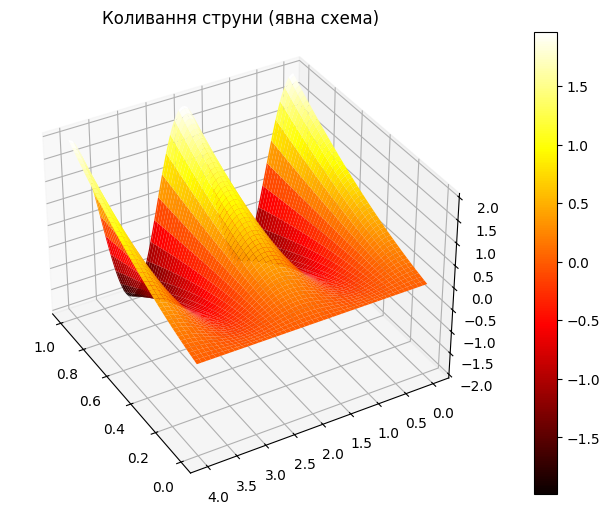

In [7]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111, projection='3d')
x_plot, t_plot = np.meshgrid(x, t)
colorbar1 = ax1.plot_surface(x_plot, t_plot, U, cmap="hot")
fig.colorbar(colorbar1, ax=ax1, fraction=0.05, pad=0.1)

ax1.view_init(elev=35, azim=60 + 90)

ax1.set_title("Коливання струни (явна схема)")
ax1.grid(True)
plt.show()

# New 2D

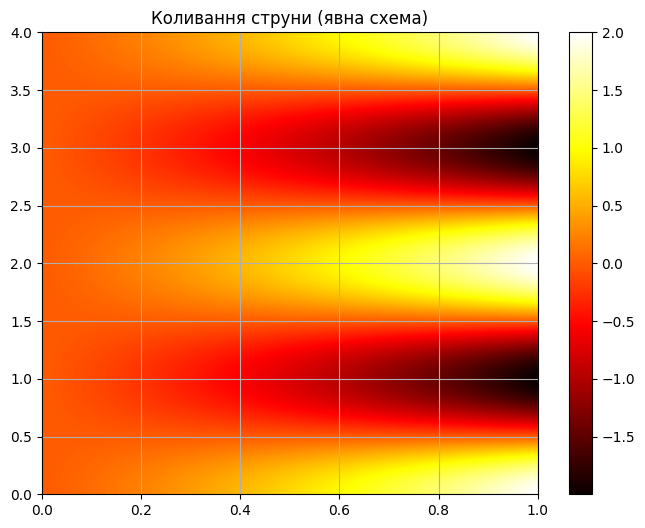

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
# colorbar = ax.imshow(U[:, ::-1].T, cmap="hot", aspect="auto", extent=[t[0], t[-1], x[-1], x[0]], origin="lower")
colorbar = ax.imshow(U, cmap="hot", aspect="auto", extent=[x[0], x[-1], t[0], t[-1]], origin="lower")
plt.colorbar(colorbar, ax=ax)

ax.set_title("Коливання струни (явна схема)")
ax.grid(True)
plt.show()

# New Animation

MovieWriter ffmpeg unavailable; using Pillow instead.


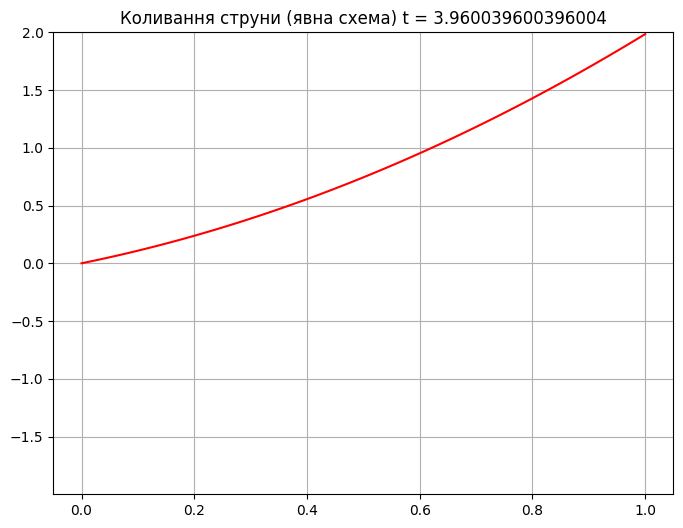

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
# line = ax.scatter(x, U[0], c=U[0])
line = ax.plot(x, U[0], "r")[0]

ax.set_title("Коливання струни (явна схема) t = 0")
ax.set_ylim(U.min(), U.max())
ax.grid(True)
every = 1000

def update(frame):
    ax.set_title(f"Коливання струни (явна схема) t = {t[frame * every]}")
    line.set_xdata(x)
    line.set_ydata(U[frame * every])
    # line.set_offsets(np.column_stack((x, U[frame * every])))
    # line.set_array(U[frame * every])
    return line

anim = animation.FuncAnimation(fig, func=update, frames=U.shape[0]//every, interval=100)
file_name = "./Images/time_string1.gif"
anim.save(file_name, fps=20)
# print("Show")
plt.show()

![Image](./Images/time_string1.gif)

# New Error

2.6053331992250673e-05


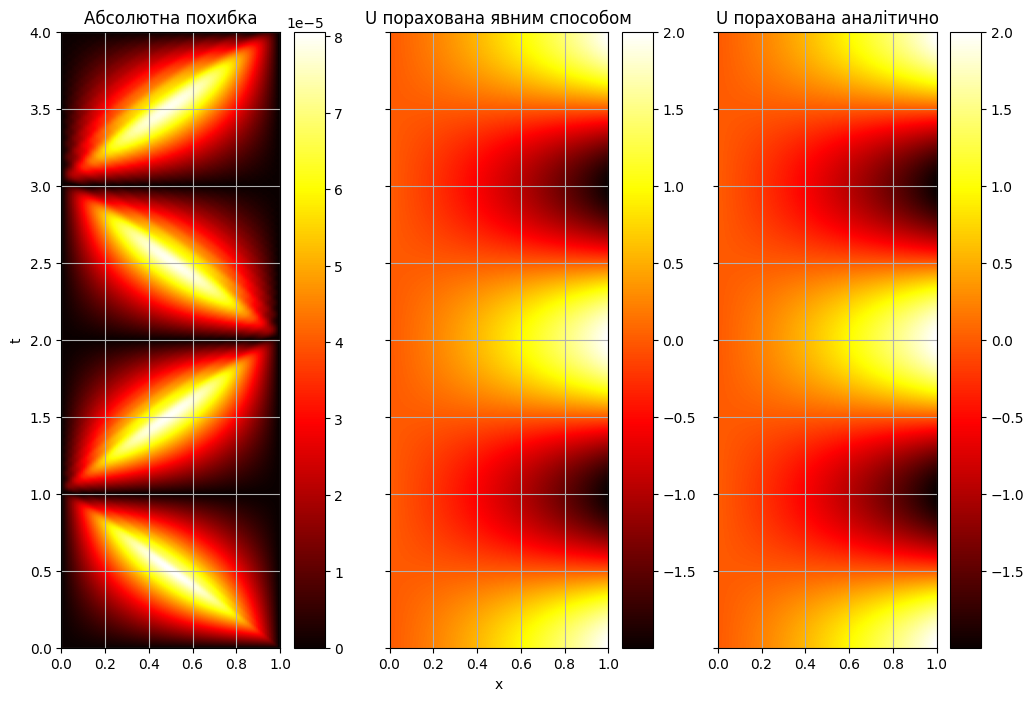

In [10]:
U_ = np.array([u(tn, x) for tn in t])

error = np.abs(U - U_)

fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)
# plt.figure(figsize=(8, 6))
color1 = ax[0].imshow(error, cmap="hot", aspect="auto", extent=[x[0], x[-1], t[0], t[-1]], origin="lower")
plt.colorbar(color1, ax=ax[0])

color2 = ax[1].imshow(U, cmap="hot", aspect="auto", extent=[x[0], x[-1], t[0], t[-1]], origin="lower")
plt.colorbar(color2, ax=ax[1])

color3 = ax[2].imshow(U_, cmap="hot", aspect="auto", extent=[x[0], x[-1], t[0], t[-1]], origin="lower")
plt.colorbar(color3, ax=ax[2])


ax[0].set_title("Абсолютна похибка")
ax[1].set_title("U порахована явним способом")
ax[2].set_title("U порахована аналітично")
ax[1].set_xlabel("x")
ax[0].set_ylabel("t")
for axe in ax:
    axe.grid(True)

print(np.mean(error))

plt.show()